In [14]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools

In [2]:
# Desicision Tree 1 using iris dataset

data = load_iris()
print('Classes to predict: ', data.target_names)
X = data.data
y = data.target

print('Number of examples in the data:', X.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 47, test_size = 0.25)

clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train, y_train)
y_pred =  clf.predict(X_test)
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=50)
clf.fit(X_train, y_train)
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf.predict(X_train)))
print('Accuracy Score on the test data: ', accuracy_score(y_true=y_test, y_pred=clf.predict(X_test)))

Classes to predict:  ['setosa' 'versicolor' 'virginica']
Number of examples in the data: 150
Accuracy Score on train data:  1.0
Accuracy Score on test data:  0.9473684210526315
Accuracy Score on train data:  0.9553571428571429
Accuracy Score on the test data:  0.9736842105263158


In [8]:
# Desicision Tree 2 using bmi dataset

def gini_impurity(y):
    if isinstance(y, pd.Series):
        p = y.value_counts()/y.shape[0]
        gini = 1-np.sum(p**2)
        return(gini)
    else:
        raise('Object must be a Pandas Series.')
    
    
def entropy(y):
    if isinstance(y, pd.Series):
        a = y.value_counts()/y.shape[0]
        entropy = np.sum(-a*np.log2(a+1e-9))
        return(entropy)
    else:
        raise('Object must be a Pandas Series.')
        

def variance(y):
    if(len(y) == 1):
        return 0
    else:
        return y.var()

    
def information_gain(y, mask, func=entropy):
    a = sum(mask)
    b = mask.shape[0] - a
    if(a == 0 or b ==0): 
        ig = 0
    else:
        if y.dtypes != 'O':
            ig = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
        else:
            ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
    return ig


def categorical_options(a):
    a = a.unique()
    opciones = []
    for L in range(0, len(a)+1):
        for subset in itertools.combinations(a, L):
            subset = list(subset)
            opciones.append(subset)
    return opciones[1:-1]


def max_information_gain_split(x, y, func=entropy):
    split_value = []
    ig = [] 
    numeric_variable = True if x.dtypes != 'O' else False
    # Create options according to variable type
    if numeric_variable:
        options = x.sort_values().unique()[1:]
    else: 
        options = categorical_options(x)
    # Calculate ig for all values
    for val in options:
        mask =   x < val if numeric_variable else x.isin(val)
        val_ig = information_gain(y, mask, func)
        ig.append(val_ig)
        split_value.append(val)

    # Check if there are more than 1 results if not, return False
    if len(ig) == 0:
        return(None,None,None, False)
    else:
    # Get results with highest IG
        best_ig = max(ig)
        best_ig_index = ig.index(best_ig)
        best_split = split_value[best_ig_index]
        return(best_ig,best_split,numeric_variable, True)
    

def get_best_split(y, data):
    masks = data.drop(y, axis= 1).apply(max_information_gain_split, y = data[y])
    if sum(masks.loc[3,:]) == 0:
        return(None, None, None, None)
    else:
        # Get only masks that can be splitted
        masks = masks.loc[:,masks.loc[3,:]]
        # Get the results for split with highest IG
        split_variable = max(masks)
        #split_valid = masks[split_variable][]
        split_value = masks[split_variable][1] 
        split_ig = masks[split_variable][0]
        split_numeric = masks[split_variable][2]
        return(split_variable, split_value, split_ig, split_numeric)


def make_split(variable, value, data, is_numeric):
    if is_numeric:
        data_1 = data[data[variable] < value]
        data_2 = data[(data[variable] < value) == False]
    else:
        data_1 = data[data[variable].isin(value)]
        data_2 = data[(data[variable].isin(value)) == False]
    return(data_1,data_2)


def make_prediction(data, target_factor):
    if target_factor:
        pred = data.value_counts().idxmax()
    else:
        pred = data.mean()
    return pred


def train_tree(data,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):
     # Check that max_categories is fulfilled
    if counter==0:
        types = data.dtypes
        check_columns = types[types == "object"].index
        for column in check_columns:
            var_length = len(data[column].value_counts()) 
            if var_length > max_categories:
                raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

    # Check for depth conditions
    if max_depth == None:
        depth_cond = True
    else:
        if counter < max_depth:
            depth_cond = True
        else:
            depth_cond = False
            
    # Check for sample conditions
    if min_samples_split == None:
        sample_cond = True
    else:
        if data.shape[0] > min_samples_split:
            sample_cond = True

        else:
            sample_cond = False

    # Check for ig condition
    if depth_cond & sample_cond:
        var,val,ig,var_type = get_best_split(y, data)
    # If ig condition is fulfilled, make split 
        if ig is not None and ig >= min_information_gain:
            counter += 1
            left,right = make_split(var, val, data,var_type)
            # Instantiate sub-tree
            split_type = "<=" if var_type else "in"
            question =   "{} {}  {}".format(var,split_type,val)
            # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val) 
            subtree = {question: []}
            # Find answers (recursion)
            yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)
            no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)
            if yes_answer == no_answer:
                subtree = yes_answer
            else:
                subtree[question].append(yes_answer)
                subtree[question].append(no_answer)

        # If it doesn't match IG condition, make prediction
        else:
            pred = make_prediction(data[y],target_factor)
            return pred

    # Drop dataset if doesn't match depth or sample conditions
    else:
        pred = make_prediction(data[y],target_factor)
        return pred
    return subtree



def clasificar_datos(observacion, arbol):
    question = list(arbol.keys())[0] 
    if question.split()[1] == '<=':
        if observacion[question.split()[0]] <= float(question.split()[2]):
            answer = arbol[question][0]
        else:
            answer = arbol[question][1]
    else:
        if observacion[question.split()[0]] in (question.split()[2]):
            answer = arbol[question][0]
        else:
            answer = arbol[question][1]

    # If the answer is not a dictionary
    if not isinstance(answer, dict):
        return answer
    else:
        residual_tree = answer
        return clasificar_datos(observacion, answer)

    
data = pd.read_csv("data.csv")
print(data.head())
data['obese'] = (data.Index >= 4).astype('int')
data.drop('Index', axis = 1, inplace = True)
print ("Misclassified when cutting at 100kg:", data.loc[(data['Weight']>=100) & (data['obese']==0),:].shape[0], "\n", 
       "Misclassified when cutting at 80kg:", data.loc[(data['Weight']>=80) & (data['obese']==0),:].shape[0])

gini_impurity(data.Gender) 
entropy(data.Gender)
information_gain(data['obese'], data['Gender'] == 'Male')
weight_ig, weight_slpit, _, _ = max_information_gain_split(data['Weight'], data['obese'],)  
print("The best split for Weight is when the variable is less than ", weight_slpit,
      "\nInformation Gain for that split is:", weight_ig)
data.drop('obese', axis= 1).apply(max_information_gain_split, y = data['obese'])

max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5
decisiones = train_tree(data,'obese',True, max_depth,min_samples_split,min_information_gain)
print(decisiones)

   Gender  Height  Weight  Index
0    Male     174      96      4
1    Male     189      87      2
2  Female     185     110      4
3  Female     195     104      3
4    Male     149      61      3
Misclassified when cutting at 100kg: 18 
 Misclassified when cutting at 80kg: 63
The best split for Weight is when the variable is less than  103 
Information Gain for that split is: 0.10625190497954848
{'Weight <=  103': [{'Weight <=  74': [0, {'Weight <=  84': [{'Weight <=  75': [1, 0]}, {'Weight <=  98': [1, 0]}]}]}, 1]}


In [11]:
# K-near 1 using iris dataset

irisData = load_iris()
X = irisData.data
y = irisData.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.9666666666666667


[[ 6  0  0]
 [ 0 10  2]
 [ 0  2 10]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         6
Iris-versicolor       0.83      0.83      0.83        12
 Iris-virginica       0.83      0.83      0.83        12

       accuracy                           0.87        30
      macro avg       0.89      0.89      0.89        30
   weighted avg       0.87      0.87      0.87        30



Text(0, 0.5, 'Mean Error')

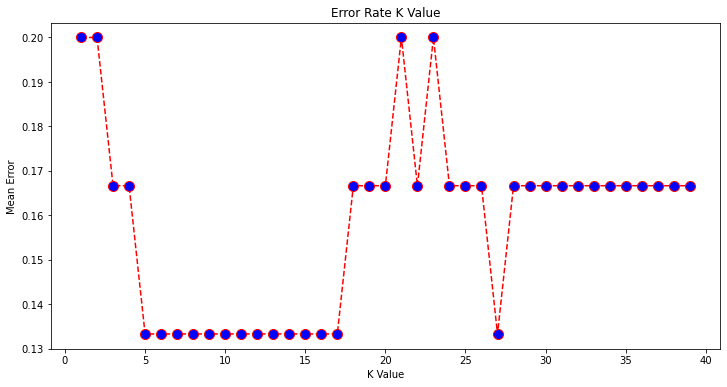

In [15]:
# K-near 2 using iris dataset

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)
dataset.head()
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 4].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')